In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### collego il drive per importare i requirements
Si installano i seguenti pacchetti:


In [ ]:
# cloudpickle==3.1.0
# gym==0.26.2
# gym-notices==0.0.8
# -e git+https://github.com/Limmen/gym-idsgame.git@d10830fef55308d383c98b41b34688a7fceae357#egg=gym_idsgame
# Gymnasium==0.29.1
# gymnasium-notices==0.0.1
# imageio==2.36.0
# jsonpickle==4.0.0
# matplotlib==3.9.2
# #numpy==2.0.2
# numpy==1.24.3
# opencv_python==4.10.0.84
# pandas==2.2.3
# pyglet==1.5.15
# pytest==8.3.3
# PyYAML==6.0.2
# scikit_learn==1.5.2
# scipy==1.13.1
# seaborn==0.13.2
# setuptools==75.4.0
# six==1.16.0
# stable_baselines3==2.3.2
# torch==2.5.1
# torchvision==0.20.1
# tqdm==4.67.0

In [3]:
!pip install -r drive/MyDrive/requirements.txt

Obtaining gym_idsgame from git+https://github.com/Limmen/gym-idsgame.git@d10830fef55308d383c98b41b34688a7fceae357#egg=gym_idsgame (from -r drive/MyDrive/requirements.txt (line 4))
  Cloning https://github.com/Limmen/gym-idsgame.git (to revision d10830fef55308d383c98b41b34688a7fceae357) to ./src/gym-idsgame
  Running command git clone --filter=blob:none --quiet https://github.com/Limmen/gym-idsgame.git /content/src/gym-idsgame
  Running command git rev-parse -q --verify 'sha^d10830fef55308d383c98b41b34688a7fceae357'
  Running command git fetch -q https://github.com/Limmen/gym-idsgame.git d10830fef55308d383c98b41b34688a7fceae357
  Running command git checkout -q d10830fef55308d383c98b41b34688a7fceae357
  Encountered 10 file(s) that should have been pointers, but weren't:
        experiments/training/v7/maximal_attack/tabular_q_learning/docs/avg_summary.png
        experiments/training/v7/maximal_attack/tabular_q_learning/docs/episode_0.gif
        experiments/training/v7/maximal_attack/t

In [1]:
import os
import time
import random
from datetime import datetime
from collections import defaultdict, deque
from typing import Union

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim

from gym_idsgame.envs.idsgame_env import IdsGameEnv
from gym_idsgame.agents.training_agents.q_learning.q_agent_config import QAgentConfig
from gym_idsgame.agents.training_agents.q_learning.q_agent import QAgent
from gym_idsgame.agents.dao.experiment_result import ExperimentResult

from experiments.util import util
import tqdm

#### Funzioni e classi utili

In [2]:
def get_output_dir(algorithm: str) -> str:
    """
    Crea e restituisce la directory di output

    Argomenti:
        algorithm: Nome dell'algoritmo utilizzato (es. "sarsa", "ddqn")

    Ritorna:
        Percorso della directory di output creata
    """
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    output_dir = f"results/training/{algorithm}_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    return output_dir


class GymCompatibilityWrapper(gym.Wrapper):
    """
    Un wrapper per rendere l'ambiente gym-idsgame compatibile con l'ultima API di Gymnasium.

    Questo wrapper gestisce le differenze tra le API di gym-idsgame e Gymnasium:
    - Gestisce il parametro update_stats nel metodo reset
    - Fornisce un metodo render compatibile con la registrazione video
    - Adatta il formato di ritorno del metodo step

    Attributi:
        env: L’ambiente gym-idsgame wrappato
    """

    def reset(self, **kwargs) -> tuple:
        """
        Reimposta l’ambiente gestendo il parametro update_stats.

        Argomenti:
            **kwargs: Argomenti opzionali per reset, incluso update_stats

        Ritorna:
            tuple: (attacker_obs, defender_obs)
        """
        update_stats = kwargs.get('update_stats', False)
        self.env.reset(update_stats=update_stats)
        return self.env.get_observation()

    def step(self, action: tuple) -> tuple:
        """
        Esegue uno step nell’ambiente.

        Adatta il metodo step per mantenere la compatibilità tra
        le API di gym-idsgame e Gymnasium.

        Argomenti:
            action: una tupla (attacker_action, defender_action)

        Ritorna:
            tuple: (osservazione, ricompensa, done, info) dove:
                - osservazione è l'osservazione completa dell’ambiente
                - ricompensa è una tupla (attacker_reward, defender_reward)
                - done indica se l'episodio è terminato
                - info è un dizionario con informazioni aggiuntive
        """
        full_obs = self.env.get_observation()
        _, reward, terminated, truncated, info = self.env.step(action)
        return full_obs, reward, terminated or truncated, info

# SARSA AGENT

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment idsgame-random_attack-v8 is out of date. You should consider upgrading to version `v21`.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:175: UserWarning: WARN: The default seed argument in `Env.reset` should be `None`, otherwise the environment will by default always be deterministic. Actual default: seed: int = 0
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: float64
  

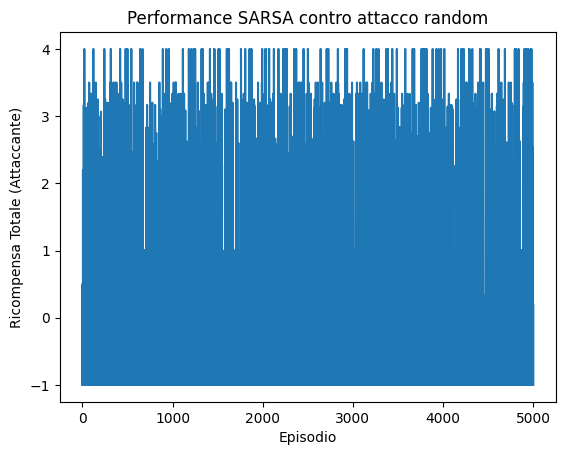

In [ ]:
# Parametri SARSA
alpha = 0.1
gamma = 0.99
epsilon = 0.1
num_episodes = 5000

random_seed = 33
output_dir = get_output_dir(algorithm='sarsa')
util.create_artefact_dirs(output_dir, random_seed)
env_name = "idsgame-random_attack-v8"
env = gym.make(env_name, save_dir=output_dir + "results/data/" + str(random_seed))
env = GymCompatibilityWrapper(env)

# Funzione ε-greedy per generare coppia di azioni
def epsilon_greedy_policy(state, Q, n_actions, epsilon):
    if np.random.rand() < epsilon:
        return (np.random.randint(n_actions), np.random.randint(n_actions))
    else:
        return max(Q[state], key=Q[state].get, default=(0, 0))

# Inizializza Q-table con valori per coppie di azioni
Q = defaultdict(lambda: {(a1, a2): 0.0 for a1 in range(env.action_space.n) for a2 in range(env.action_space.n)})
episode_rewards = []

for episode in range(num_episodes):
    state, _ = env.reset(seed=None)
    state = str(state)
    action = epsilon_greedy_policy(state, Q, env.action_space.n, epsilon)

    done = False
    total_reward = 0
    while not done:
        next_state, reward, done, info = env.step(action)
        next_state = str(next_state)
        next_action = epsilon_greedy_policy(next_state, Q, env.action_space.n, epsilon)

        attacker_reward, defender_reward = reward
        Q[state][action] += alpha * (
            attacker_reward + gamma * Q[next_state][next_action] - Q[state][action]
        )

        state = next_state
        action = next_action
        total_reward += attacker_reward

    episode_rewards.append(total_reward)

env.close()

# Grafico dei risultati
plt.plot(episode_rewards)
plt.xlabel("Episodio")
plt.ylabel("Ricompensa Totale (Attaccante)")
plt.title("Performance SARSA contro attacco random")
plt.show()

#### SARSA arriva ad una ricompensa totale dell'attaccante massima di 4 senza convergere. Proviamo ad usare una Deep Q network

# DDQN

#### Funzioni

In [3]:
# Definizione della rete neurale
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# def preprocess_state(state):
#     if isinstance(state, tuple):
#         # Converti entrambi i blocchi a int32 prima di flatten
#         return np.concatenate([s.astype(np.int32).flatten() for s in state])
#     elif isinstance(state, np.ndarray):
#         return state.astype(np.int32).flatten()
#     else:
#         raise ValueError("Formato dello stato non supportato.")
def preprocess_state(state):
    if isinstance(state, tuple):
        # Esempio: random_attack-v8
        return np.concatenate([s.astype(np.int32).flatten() for s in state])
    elif isinstance(state, np.ndarray):
        # Esempio: maximal_attack-v8 → espandi a 66 con padding fittizio
        dummy = np.zeros_like(state)
        return np.concatenate([state.astype(np.int32).flatten(), dummy.flatten()])
    else:
        raise ValueError("Formato dello stato non supportato.")

# Definizione dell'agente DDQN
class DDQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, epsilon=1.0,
                 epsilon_min=0.01, epsilon_decay=0.995, batch_size=64, memory_size=10000,
                 target_update_freq=10):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.target_update_freq = target_update_freq
        self.learn_step_counter = 0

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net = DQN(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()

    def store_transition(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        current_q = self.policy_net(states).gather(1, actions)
        next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
        next_q = self.target_net(next_states).gather(1, next_actions)
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = self.loss_fn(current_q, target_q.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Random attack

#### stampiamo molti log per cercare di capire eventuali problemi nel modello

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment idsgame-random_attack-v8 is out of date. You should consider upgrading to version `v21`.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:175: UserWarning: WARN: The default seed argument in `Env.reset` should be `None`, otherwise the environment will by default always be deterministic. Actual default: seed: int = 0
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: float64
  

[Ep 0 | Step 0] Azione: 8, Attacker R: 0, Defender R: 0, R_shaped: 0.00, Done: False
[Ep 0 | Step 0] Loss aggiornata, Epsilon: 1.000
[Ep 0 | Step 1] Azione: 23, Attacker R: 0, Defender R: 0, R_shaped: 0.00, Done: False
[Ep 0 | Step 1] Loss aggiornata, Epsilon: 1.000
[Ep 0 | Step 2] Azione: 0, Attacker R: -1, Defender R: 1, R_shaped: -1.50, Done: True
[Ep 0 | Step 2] Loss aggiornata, Epsilon: 1.000
[Episodio 1] Ricompensa totale attaccante = -1.5, Epsilon = 1.000
[Ep 1 | Step 0] Azione: 13, Attacker R: 0, Defender R: 0, R_shaped: 0.00, Done: False
[Ep 1 | Step 0] Loss aggiornata, Epsilon: 1.000
[Ep 1 | Step 1] Azione: 13, Attacker R: -1, Defender R: 1, R_shaped: -1.50, Done: True
[Ep 1 | Step 1] Loss aggiornata, Epsilon: 1.000
[Episodio 2] Ricompensa totale attaccante = -1.5, Epsilon = 1.000
[Ep 2 | Step 0] Azione: 26, Attacker R: 2, Defender R: 0, R_shaped: 2.00, Done: False
[Ep 2 | Step 0] Loss aggiornata, Epsilon: 1.000
[Ep 2 | Step 1] Azione: 0, Attacker R: 0, Defender R: 0, R_shape

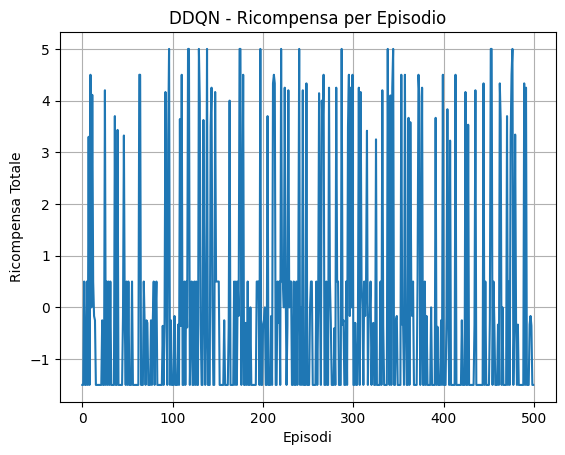

In [ ]:
# Inizializzazione dell'ambiente
env_name = "idsgame-random_attack-v8"
env = gym.make(env_name)

# Ottieni un esempio di stato per calcolare la dimensione dello stato
raw_state, _ = env.reset()
state = preprocess_state(raw_state)
state_dim = state.shape[0]
action_dim = env.action_space.n

# Inizializza l'agente
agent = DDQNAgent(state_dim, action_dim)

num_episodes = 500
reward_history = []

for episode in range(num_episodes):
    raw_state, _ = env.reset(seed=None)
    state = preprocess_state(raw_state)

    total_reward = 0
    done = False
    step_count = 0

    while not done:
        action = agent.select_action(state)

        # Gymnasium API
        raw_next_state, reward, terminated, truncated, info = env.step((action, 0))
        done = terminated or truncated

        # Reward shaping migliorato
        attacker_reward, defender_reward = reward
        reward_signal = float(attacker_reward - 0.5 * defender_reward)

        # Preprocess stato successivo
        next_state = preprocess_state(raw_next_state)

        # Debug reward shaping
        print(f"[Ep {episode} | Step {step_count}] "
              f"Azione: {action}, "
              f"Attacker R: {attacker_reward}, Defender R: {defender_reward}, "
              f"R_shaped: {reward_signal:.2f}, Done: {done}")

        # Salva transizione e aggiorna
        agent.store_transition(state, action, reward_signal, next_state, done)

        # Update con logging loss
        prev_epsilon = agent.epsilon
        agent.update()
        if agent.learn_step_counter % agent.target_update_freq == 0:
            print(f"[Ep {episode} | Step {step_count}] Loss aggiornata, Epsilon: {prev_epsilon:.3f}")

        # Passaggio al nuovo stato
        state = next_state
        total_reward += reward_signal
        step_count += 1

    reward_history.append(total_reward)
    print(f"[Episodio {episode + 1}] Ricompensa totale attaccante = {total_reward}, Epsilon = {agent.epsilon:.3f}")

env.close()

# Grafico dei risultati
plt.plot(reward_history)
plt.xlabel("Episodi")
plt.ylabel("Ricompensa Totale")
plt.title("DDQN - Ricompensa per Episodio")
plt.grid(True)
plt.show()

Durante l’addestramento, l’agente DDQN oscilla tra ricompense totali comprese tra -1 e 5, con alcuni episodi significativamente migliori della media ma senza una chiara tendenza alla convergenza. Questo comportamento suggerisce un apprendimento parziale ma instabile.

Le cause più probabili includono:

*   Ricompensa troppo sparsa o poco informativa: l’agente riceve segnali utili troppo raramente o in modo non coerente
*   Parametri non ottimali: valori di batch_size, learning_rate, epsilon_decay, target_update_freq o memory_size potrebbero non essere bilanciati correttamente per questo task
*  Learning instabile: dovuto a problemi di ottimizzazione come gradienti instabili, overestimation bias residuo o mancanza di normalizzazione.
*   Learning instabile: dovuto a problemi di ottimizzazione come gradienti instabili, overestimation bias residuo o mancanza di normalizzazione
*   Architettura o preprocessing non perfettamente allineati: input non normalizzati, osservazioni fuori dallo observation_space o mismatch tra dimensione attesa ed effettiva dello stato possono compromettere l'apprendimento
*   Difficoltà intrinseca del task maximal_attack-v8: l'ambiente può risultare troppo penalizzante, con poco margine di manovra per l’attaccante



Per migliorare la stabilità, si potrebbe provare, ad esempio:

*   Diversi set di iperparametri tramite grid search o tuning manual
*   L’utilizzo di tecniche come Huber loss, gradient clipping e normalizzazione dell’input









## Maximal attack

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment idsgame-maximal_attack-v8 is out of date. You should consider upgrading to version `v21`.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:175: UserWarning: WARN: The default seed argument in `Env.reset` should be `None`, otherwise the environment will by default always be deterministic. Actual default: seed: int = 0
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be int32, actual type: float64
 

[Ep 0 | Step 0] Azione: 0, Attacker R: 2, Defender R: 0, R_shaped: 2.00, Done: False
[Ep 0 | Step 0] Loss aggiornata, Epsilon: 1.000
[Ep 0 | Step 1] Azione: 15, Attacker R: 0, Defender R: 0, R_shaped: 0.00, Done: False
[Ep 0 | Step 1] Loss aggiornata, Epsilon: 1.000
[Ep 0 | Step 2] Azione: 1, Attacker R: -1, Defender R: 1, R_shaped: -1.50, Done: True
[Ep 0 | Step 2] Loss aggiornata, Epsilon: 1.000
[Episodio 1] Ricompensa totale attaccante = 1, Epsilon = 1.000
[Ep 1 | Step 0] Azione: 28, Attacker R: 2, Defender R: 0, R_shaped: 2.00, Done: False
[Ep 1 | Step 0] Loss aggiornata, Epsilon: 1.000
[Ep 1 | Step 1] Azione: 9, Attacker R: 0, Defender R: 0, R_shaped: 0.00, Done: False
[Ep 1 | Step 1] Loss aggiornata, Epsilon: 1.000
[Ep 1 | Step 2] Azione: 28, Attacker R: -1, Defender R: 1, R_shaped: -1.50, Done: True
[Ep 1 | Step 2] Loss aggiornata, Epsilon: 1.000
[Episodio 2] Ricompensa totale attaccante = 1, Epsilon = 1.000
[Ep 2 | Step 0] Azione: 10, Attacker R: 2, Defender R: 0, R_shaped: 2.0

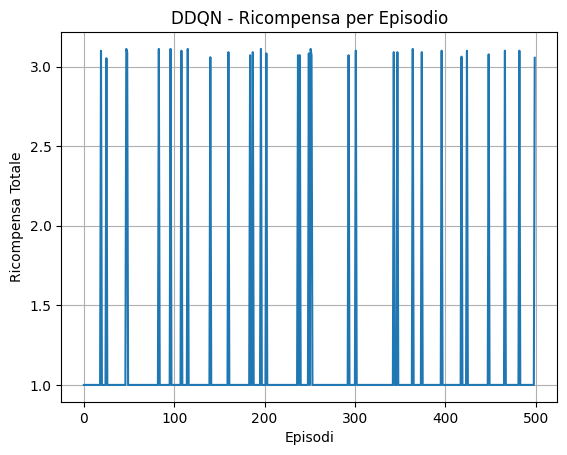

In [7]:
env_name = "idsgame-maximal_attack-v8"
# Inizializzazione ambiente
env = gym.make(env_name)
env = GymCompatibilityWrapper(env)

# Ottieni un esempio di stato per calcolare la dimensione dello stato
raw_state, _ = env.reset()
state = preprocess_state(raw_state)
state_dim = state.shape[0]
action_dim = env.action_space.n

# Inizializza agente
agent = DDQNAgent(state_dim, action_dim)

num_episodes = 500
reward_history = []

for episode in range(num_episodes):
    raw_state, _ = env.reset(seed=None)
    state = preprocess_state(raw_state)

    total_reward = 0
    done = False
    step_count = 0

    while not done:
        action = agent.select_action(state)

        # Step con Gymnasium
        raw_next_state, reward, done, info = env.step((action, 0))
        attacker_reward, defender_reward = reward

        # Reward shaping
        if attacker_reward > 0:
            reward_signal = attacker_reward  # positivo se colpisce
        elif done:
            reward_signal = -1.5
        else:
            reward_signal = 0.0  # neutro se non succede nulla

        next_state = preprocess_state(raw_next_state)

        # Logging step-by-step
        print(f"[Ep {episode} | Step {step_count}] Azione: {action}, "
              f"Attacker R: {attacker_reward}, Defender R: {defender_reward}, "
              f"R_shaped: {reward_signal:.2f}, Done: {done}")

        # Salvataggio ed update
        agent.store_transition(state, action, reward_signal, next_state, done)
        prev_epsilon = agent.epsilon
        agent.update()
        if agent.learn_step_counter % agent.target_update_freq == 0:
            print(f"[Ep {episode} | Step {step_count}] Loss aggiornata, Epsilon: {prev_epsilon:.3f}")

        # Avanza stato
        state = next_state
        total_reward += attacker_reward
        step_count += 1

    reward_history.append(total_reward)
    print(f"[Episodio {episode + 1}] Ricompensa totale attaccante = {total_reward}, Epsilon = {agent.epsilon:.3f}")

env.close()

# Grafico dei risultati
plt.plot(reward_history)
plt.xlabel("Episodi")
plt.ylabel("Ricompensa Totale")
plt.title("DDQN - Ricompensa per Episodio")
plt.grid(True)
plt.show()

L’agente DDQN nel task maximal_attack-v8 mostra un comportamento inizialmente ripetitivo ma con segni chiari di apprendimento parziale.
Con la progressiva decrescita dell’esplorazione (epsilon in calo), cominciano a emergere episodi più lunghi e ricompense superiori a 2 o anche 3.
In pochi casi l’agente ottiene 3+, ma questi episodi restano isolati, non indicano convergenza stabile.
Il valore di epsilon decresce come previsto, ma i miglioramenti nella policy sono modesti.


Possibili miglioramenti potrebbero essere:

*   Diversificare il reward shaping epr introdurre una scala più fine o premiare progressi intermedi
*   Rallentare l’epsilon decay per permettere più esplorazione

